# CBS Week 4 Tutorial: Categorization
## Semester 2 2021


In [1]:
library(tidyverse)
library(janitor)
library(nimble)
options(repr.plot.width=10, repr.plot.height=5)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


nimble version 0.11.1 is loaded.
For more information on NIMBLE and a User Manual,
please visit http://R-nimble.org.


Attaching package: ‘nimble’


The following object is masked from ‘package:stats’:

    simulate




This tutorial focuses on exemplar and prototype models of categorization. To keep things simple we'll focus on a one-dimensional example. Imagine a set of objects that vary along one dimension --- for example the dimension of "spikiness":

<figure>
  <img src="images/spikiness.jpg" alt="spikiness" style="width:50%">
  <figcaption  class="figure-caption text-center">
Figure 1: Objects that vary along the dimension of spikiness. From Gibson, Rogers & Zhu (2013), Human semi-supervised learning
    </figcaption>
</figure>

We'll use some data where 9 objects are organized into two categories. Let `x` indicate the spikiness of each object, and `z` denote its category label. Because we're looking at a *supervised* problem, the category label of each object is known. In this made-up data set, objects that are relatively spiky or relatively smooth belong to category 1, and objects between these extremes belong to category 2.

In [2]:
data_1d <- tibble(x = c(-1.0, -0.8, -0.6, 1.5, 1.7, 0.6, 0.8, 1.0, 1.1),
                  z = factor( c(1, 1, 1, 1, 1, 2, 2, 2, 2) ))
print(data_1d)

# A tibble: 9 x 2
      x z    
  <dbl> <fct>
1  -1   1    
2  -0.8 1    
3  -0.6 1    
4   1.5 1    
5   1.7 1    
6   0.6 2    
7   0.8 2    
8   1   2    
9   1.1 2    


# Exemplar model

Given a set of examples where $z=1$, an exemplar model computes the probability density for category 1 (ie $p(x|z=1)$) by dropping a Gaussian kernel (ie a Gaussian bump) on each example, adding up all these kernels, and renormalizing to make sure that the density integrates to 1. 

Let's plot densities for both category 1 (`z=1`) and category 2 (`z=2`). We'll assume that the standard deviation of each Gaussian bump (also known as the kernel bandwidth) is `mybw = 0.3`. 


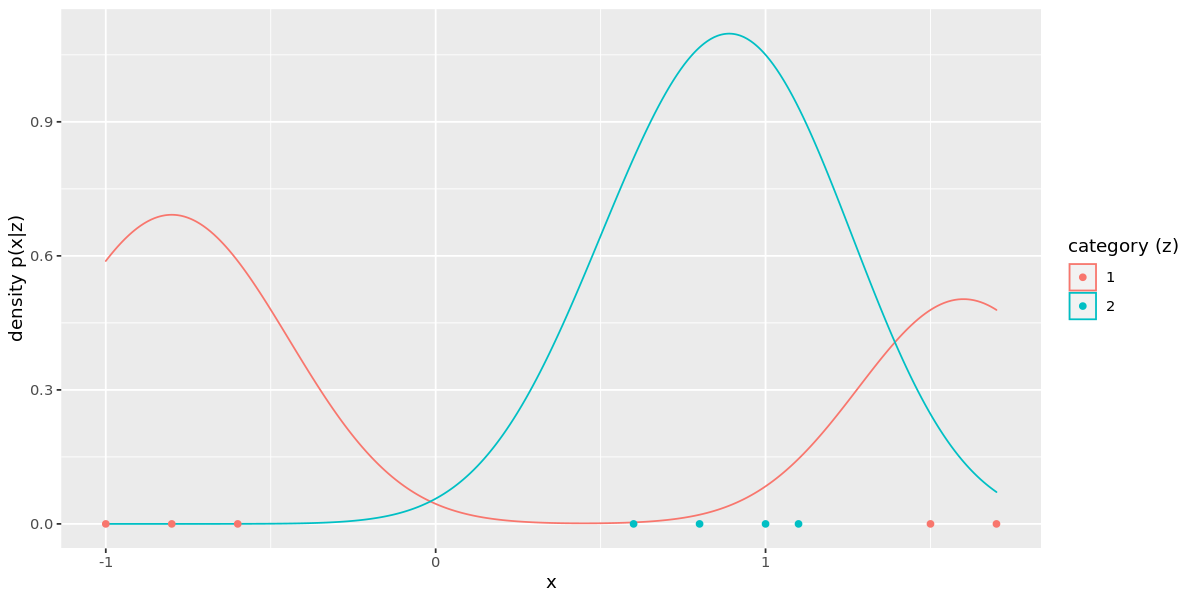

In [3]:
                                      # "nrd" specifies a method for choosing the bandwidth if 
                                      #  this parameter is not supplied
exemplar_plot_1d <- function(data, bw="nrd") {
  e_plot <-  data %>% 
    ggplot(aes(x = x, color = z, group = z)) +
    geom_density(bw = bw) +
    geom_point(aes(x=x, y=0)) +
    labs(color='category (z)') +
    ylab("density p(x|z)")
}

mybw = 0.3
eplot_mybw <- exemplar_plot_1d(data_1d, bw=mybw) 
print(eplot_mybw)

In [4]:
head(data_1d)

x,z
<dbl>,<fct>
-1.0,1
-0.8,1
-0.6,1
1.5,1
1.7,1
0.6,2


If we make the kernel bandwidth much smaller you can tell that the category densities are created by adding up kernels centred on each example.



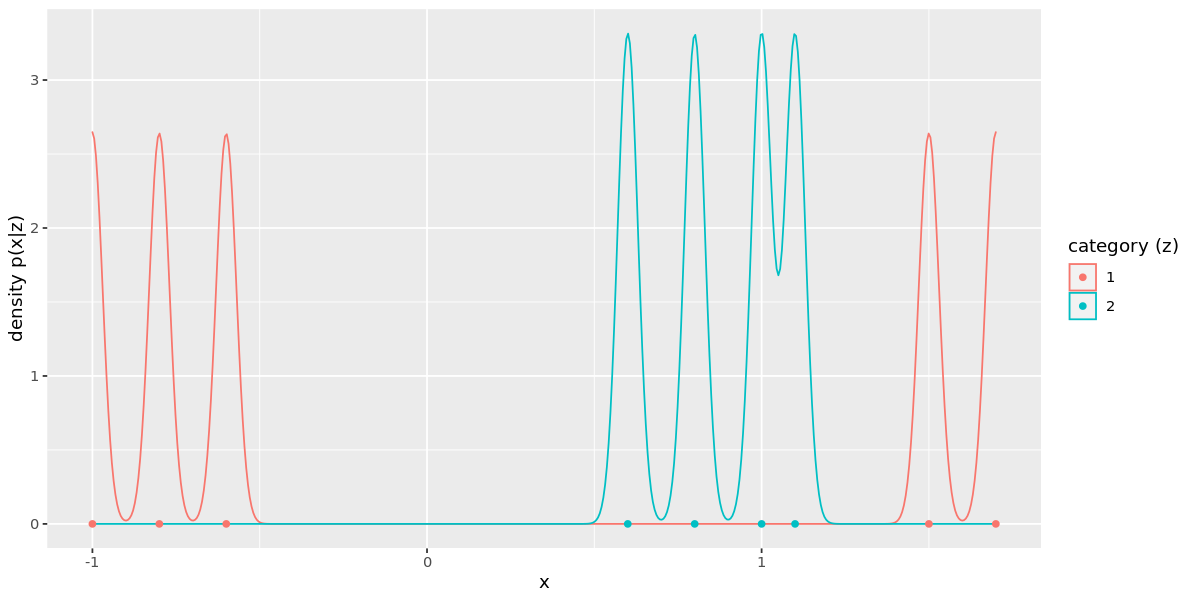

In [5]:
print(exemplar_plot_1d(data_1d, bw=0.03) ) 

Suppose that we're given a new object with $x = 0$ and we want to know the probability that this object belongs to category 1. More generally, we might want to compute a classification function $P(z=1|x)$ that we can use to estimate the probability that a new object anywhere along the dimension belongs to category 1.

Bayes rule tells us that $P(z=1|x) \propto P(x|z) P(z=1)$. Even though we plotted $p(x|z=1)$ and $p(x|z=2)$ in Figure 2 we don't have these curves stored as data structures. So let's set up a function for computing the likelihood $P(x|z)$. 

In [6]:
# compute p(XNEW|z=CATEGORY)  based on the observations in DATA
p_x_given_z <- function(data, category, xnew, bw = mybw){
  newval <- data %>% 
    filter(z == category) %>% 
    mutate(k_val = dnorm(xnew, mean = x, sd = bw)) %>% 
    summarize(mean_k_val = mean(k_val)) %>% 
    pull()
}

In [7]:
category <- 2
xnew <- .5
bw <- mybw
data_1d %>%
filter(z == category) %>%
mutate(k_val = dnorm(xnew, mean = x, sd = mybw)) %>%
summarize(mean_k_val = mean(k_val))

mean_k_val
<dbl>
0.6440184


In [8]:
category <- 1
data_1d %>% 
    filter(z == category)

x,z
<dbl>,<fct>
-1.0,1
-0.8,1
-0.6,1
1.5,1
1.7,1


In [9]:
category <- 2
xnew <- 0.1
bw <- mybw

data_1d %>% 
filter(z == category)%>%
mutate(k_val = dnorm(xnew, mean = x, sd = bw))

x,z,k_val
<dbl>,<fct>,<dbl>
0.6,2,0.33159046
0.8,2,0.08740630
1.0,2,0.01477283
1.1,2,0.00514093


In [10]:
category <- 2
xnew <- 0.1
bw <- mybw

data_1d %>% 
filter(z == category)%>%
mutate(k_val = dnorm(xnew, mean = x, sd = bw)) %>%
summarize(mean_k_val = mean(k_val))

mean_k_val
<dbl>
0.1097276


We'll also set up a function to compute the prior.  We'll assume that $P(z=1)$ corresponds to the proportion of observed examples that belong to category 1. For the data set we've been working with $P(z=1) = \frac{5}{9}$.

In [11]:
# compute p(z=CATEGORY) based on the observations in DATA
p_z <- function(data, category){
  sum(data$z == category)/nrow(data)
}

We'll now multiply the prior and likelihood then renormalize to compute $p(z=1|x)$ over a grid of points between -3 and 3:

In [12]:
classification_curve <- function(data, bw = mybw) {
  classifications <- tibble(x = seq(-3, 3, 0.01)) %>% 
    # compute p(z) for all x
    mutate(p_z1 = p_z(data, 1)) %>% 
    mutate(p_z2 = p_z(data, 2)) %>% 
    # compute p(x|z) 
    mutate(p_x_given_z1 = map_dbl(x, ~p_x_given_z(data, 1, ., bw))) %>% 
    mutate(p_x_given_z2 = map_dbl(x, ~p_x_given_z(data, 2, ., bw))) %>% 
    # compute p(z|x) up to normalizing constant
    mutate(p_z1_given_x = p_x_given_z1*p_z1) %>% 
    mutate(p_z2_given_x = p_x_given_z2*p_z2) %>% 
    # normalize p(z|x) 
    mutate(p_z1_given_x = p_z1_given_x /(p_z1_given_x + p_z2_given_x)) %>% 
    mutate(p_z2_given_x =  1 - p_z1_given_x )
}  

classifications <-classification_curve(data_1d, mybw) 
head(classifications)

x,p_z1,p_z2,p_x_given_z1,p_x_given_z2,p_z1_given_x,p_z2_given_x
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-3.00,0.5555556,0.4444444,5.996800e-11,1.789134e-32,1,0
-2.99,0.5555556,0.4444444,7.486523e-11,2.667607e-32,1,0
-2.98,0.5555556,0.4444444,9.335988e-11,3.973000e-32,1,0
-2.97,0.5555556,0.4444444,1.162947e-10,5.910616e-32,1,0
-2.96,0.5555556,0.4444444,1.447036e-10,8.783435e-32,1,0
-2.95,0.5555556,0.4444444,1.798533e-10,1.303808e-31,1,0


Now we can plot the classification curve. As you might expect, the exemplar model assigns very spiky and very smooth objects to category 1.

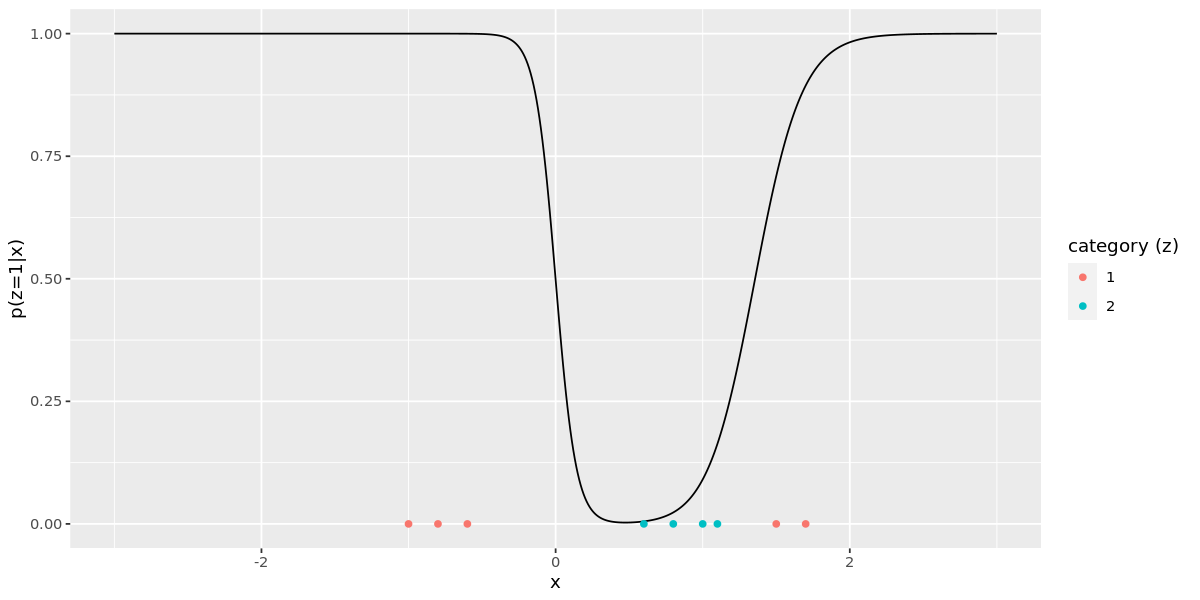

In [13]:
classification_plot_1d <- function(classifications, data) {
  c_plot <-  classifications %>% 
    ggplot(aes(x = x, y = p_z1_given_x)) +
    geom_line() +
    geom_point(data = data, aes(x = x, y = 0, color = z, group = z)) +
    labs(color='category (z)') +
    ylab("p(z=1|x)")
}
print(classification_plot_1d(classifications, data_1d))

Let's try another data set with category 1 observations at `{-0.6, -0.5, -0.4}` and category 2 observations at `{0.4, 0.41, 0.42}`. For both categories the point closest to 0 lies at a distance of 0.4 from `x=0`. The category 1 exemplars, however, are spaced more widely than are the category 2 exemplars. Again we'll plot the category densities ...

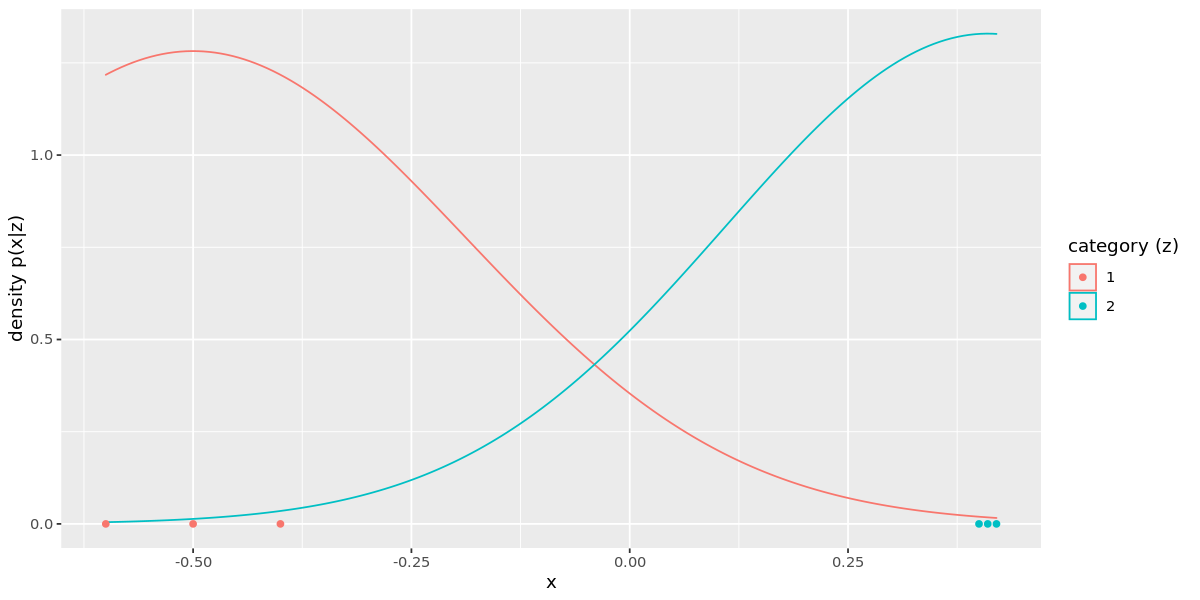

In [14]:
data_1d_spacing <- tibble(x = c(-0.6, -0.5, -0.4, 0.4,0.41,0.42),
                  z = factor( c(1,1,1,2,2,2) ))
print(exemplar_plot_1d(data_1d_spacing, bw=mybw))

... and the classification function:

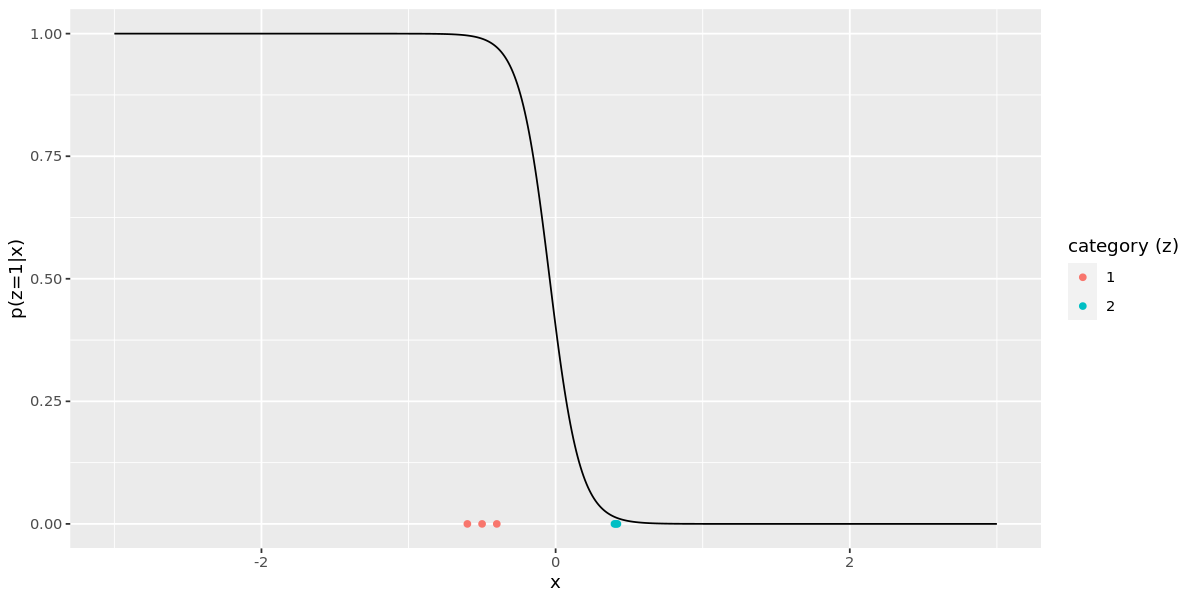

In [15]:
classifications_spacing <-classification_curve(data_1d_spacing, mybw) 
print(classification_plot_1d(classifications_spacing, data_1d_spacing))

### Exercise 1

The classification function for the 1D data set with variable spacing indicates that a new object at `x=0` is more likely to belong to category 2 than to category 1. Explain why the exemplar model makes this prediction.


YOUR ANSWER HERE

# Prototype model

Now let's build a prototype model using NIMBLE. We'll assume that category $i$ corresponds to a Gaussian distribution with mean `mu_i` and variance `s2_i`. We'll need to specify priors on these distributions, and the code below uses uniform priors. Let's start with the original data set `data_1d`.

In [17]:
code <- nimbleCode({
  for(i in 1:M) {
    mu[i] ~ dunif(-2,2)  # uniform prior on the interval [-2,2]
    s2[i] ~ dunif(0,2)    # uniform prior on the interval [0,2]
  }  
  
  pz2 ~ dunif(0,1)        # base rate of category 2 drawn from a uniform prior on the interval [0,1]
  
  for(i in 1:N) {
    # z_ind is a vector of indicator variables (0 or 1)
    # z_ind[i] is generated by flipping a weighted coin where the weight is pz2
    z_ind[i] ~ dbern(pz2)       
    # each data point x is drawn from a Gaussian distribution. We need to add 1 to z_ind to map the 
    # indicator variables (0 or 1) to categories 1 and 2
    x[i] ~ dnorm(mu[z_ind[i]+1], var = s2[z_ind[i]+1])  
  }  
})

constants <- list(
 M = 2,
 N = length(data_1d$x)
)

data <- list(
 x = data_1d$x,
 z_ind = as.numeric(data_1d$z) - 1
)

inits <- list(
 pz2 = 0.5,
 mu= c(0, 0),
 s2= c(1, 1)
)

samples <- nimbleMCMC(
    code = code,
    constants = constants,
    data = data,
    inits = inits,
    monitors = c("mu", "s2", "pz2"),
)

samples_1d <- as_tibble(samples) %>% 
  clean_names()

head(samples_1d)

defining model...

building model...

setting data and initial values...

running calculate on model (any error reports that follow may simply reflect missing values in model variables) ... 


checking model sizes and dimensions...


checking model calculations...

model building finished.

compiling... this may take a minute. Use 'showCompilerOutput = TRUE' to see C++ compilation details.

compilation finished.

running chain 1...



|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


mu_1,mu_2,pz2,s2_1,s2_2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.4808100,0.5858997,0.5923895,1.809947,1.0000000
-0.9339593,0.6597238,0.5923895,1.809947,1.0000000
-1.1995497,0.6597238,0.5923895,1.809947,0.5065783
-1.1244993,0.5583882,0.5923895,1.809947,0.5065783
-1.1244993,0.5583882,0.4945747,1.809947,0.5065783
-0.3868871,0.8646462,0.4945747,1.554952,0.5065783


Now that we have our samples let's take the mean of each column.

In [18]:
colMeans(samples_1d)

mu_1      mu_2       pz2      s2_1      s2_2 
0.1505628 0.8791447 0.4549539 1.3941429 0.4111058

### Exercise 2

Explain why the variance for category 1 (ie `s2_1`) is bigger than the variance for category 2 (`s2_2`)


YOUR ANSWER HERE

We can compute the likelihood $p(x|z)$ according to the prototype model by *summing out* (ie averaging over possible values of) the parameters `mu` and `s2`. 

In [19]:
# First put samples_1d in long form.
samples_1d_long <- samples_1d %>% 
   pivot_longer(c("mu_1", "mu_2", "s2_1", "s2_2"), names_to = c(".value", "z"), names_sep="_") %>% 
   mutate(z = as.numeric(z))

# compute p(x=X|z=CATEGORY)  based on the samples in SAMPLES
p_x_given_z_prot <- function(samples, category, x){
  xval <- samples %>% 
    filter(z == category) %>% 
    mutate(x_given_z = dnorm(x, mean = mu, sd = sqrt(s2))) %>% 
    summarize(mean_x_given_z = mean(x_given_z)) %>% 
    pull()
}

In [23]:
category <- 2
x <- 0.4
samples_1d_long %>%
filter(z == category) %>%
mutate(x_given_z = dnorm(x, mean = mu, sd = sqrt(s2))) %>%
summarize(mean_x_given_z = mean(x_given_z))

mean_x_given_z
<dbl>
0.3917575


We'll also use the samples to estimate $P(z=1)$ and $P(z=2)$:

In [18]:
# compute p(z=CATEGORY)  based on the samples in SAMPLES
p_z_prot <- function(samples, category){
  pz <- samples %>% 
    mutate(pz1 = 1 - pz2) %>% 
    filter(z == category) %>% 
    mutate(pz = if_else(z == 1, pz1, pz2)) %>% 
    summarize(mean_pz = mean(pz)) %>% 
    pull()
}

Now we can multiply the prior and likelihood then renormalize to compute $p(z=1|x)$ over a grid of points between -3 and 3.

In [32]:
classification_curve_prot <- function(samples) {
  pz1 = p_z_prot(samples, 1)  
  pz2 = p_z_prot(samples, 2)  
  classifications <- tibble(x = seq(-3, 3, 0.01)) %>% 
    # compute p(z) for all x
    mutate(p_z1 = pz1) %>% 
    mutate(p_z2 = pz2) %>% 
    # compute p(x|z) 
    mutate(p_x_given_z1 = map_dbl(x, ~p_x_given_z_prot(samples, 1, .))) %>% 
    mutate(p_x_given_z2 = map_dbl(x, ~p_x_given_z_prot(samples, 2, .))) %>% 
    # compute p(z|x) up to normalizing constant
    mutate(p_z1_given_x = p_x_given_z1*p_z1) %>% 
    mutate(p_z2_given_x = p_x_given_z2*p_z2) %>% 
    # normalize p(z|x) 
    mutate(p_z1_given_x = p_z1_given_x /(p_z1_given_x + p_z2_given_x)) %>% 
    mutate(p_z2_given_x =  1 - p_z1_given_x )
}  

classifications <-classification_curve_prot(samples_1d_long) 
head(classifications)

ERROR: Error in p_z_prot(samples, 1): could not find function "p_z_prot"


Let's plot the categories inferred by the model ...

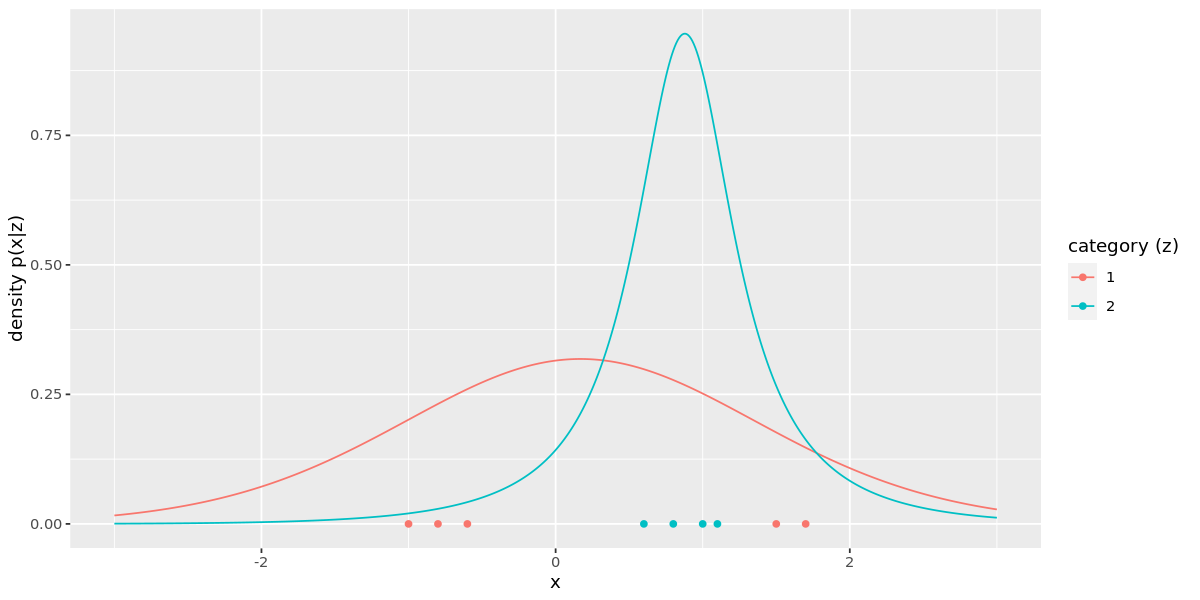

In [20]:
categorydensity_plot_1d <- function(classifications, data) {
  c_plot <-  classifications %>% 
    pivot_longer(cols=c("p_x_given_z1", "p_x_given_z2"), names_to = "z", values_to = "p_x") %>% 
    mutate(z = factor(recode(z, "p_x_given_z1"=1, "p_x_given_z2"=2))) %>% 
    ggplot(aes(x = x, y = p_x, color = z, group = z )) +
    geom_line() +
    geom_point(data = data, aes(x = x, y = 0, color = z, group = z)) +
    labs(color='category (z)') +
    ylab("density p(x|z)")
}

print(categorydensity_plot_1d(classifications, data_1d))

and the classification function: 

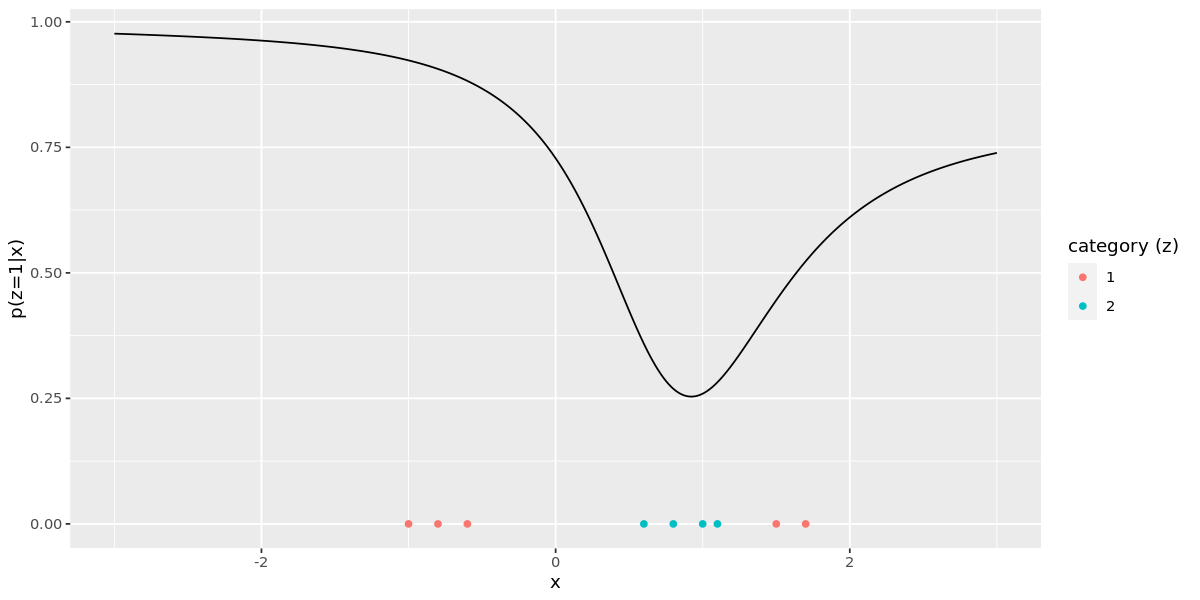

In [21]:
print(classification_plot_1d(classifications, data_1d))

### Exercise 3

The mean of category 1 is smaller than the mean of category 2. So why does the prototype model predict that objects with large values of x (greater than 1.65 or so) belong to category 1?


YOUR ANSWER HERE

Let's now apply the prototype model to the data set with variable spacing. We'll need to run NIMBLE again to collect a bag of samples. The NIMBLE code stays the same as before but we need to adjust the `constants` and `data`:

In [ ]:
constants <- list(
 M = 2,
 N = length(data_1d_spacing$x)
)

data <- list(
 x = data_1d_spacing$x,
 z_ind = as.numeric(data_1d_spacing$z) - 1
)

samples <- nimbleMCMC(
    code = code,
    constants = constants,
    data = data,
    inits = inits,
    monitors = c("mu", "s2", "pz2")
)

samples_1d_spacing_long <- as_tibble(samples) %>% 
  clean_names() %>% 
  pivot_longer(c("mu_1", "mu_2", "s2_1", "s2_2"), names_to = c(".value", "z"), names_sep="_") %>% 
   mutate(z = as.numeric(z))

Now we can use these samples to plot the category densities and classification function.

In [ ]:
classifications_spacing <-classification_curve_prot(samples_1d_spacing_long) 
print(categorydensity_plot_1d(classifications_spacing, data_1d_spacing))
print(classification_plot_1d(classifications_spacing, data_1d_spacing))

### Exercise 4

The prototype model model predicts that a new object at `x=0` is more likely to belong to category 1 than to category 2, which is different from what the exemplar model predicted. Why does the prototype model make the prediction that it does?


YOUR ANSWER HERE

### Exercise 5

A behavioral experiment could be used to determine whether people's inferences about the variable spacing data set are more consistent with the prototype model or the exemplar model. Which model do you think would account better for people's judgments about a novel object at $x=0$?  Why?


YOUR ANSWER HERE

## Behavioral experiments

There is a large literature comparing the performance of models including exemplar and prototype models with human categorization. Experiment 2 of Fried and Holyoak (1984), [Induction of Category Distributions: A Framework for Classification Learning]( http://reasoninglab.psych.ucla.edu/KH%20pdfs/Fried_Holyoak.1984.pdf ) suggests that the prototype model may account better than the exemplar model for the variable spacing example.

Across the entire experimental literature, however, the exemplar model generally tends to perform better than the prototype model as an account of human inferences.  One paper describing an experiment where the exemplar model performs very well is Nosofsky (1989), [Further tests of an exemplar similarity approach to relating identification and categorization](  https://link.springer.com/content/pdf/10.3758/BF03204942.pdf ), and you'll learn more about this experiment in the assessment for this week.

## OPTIONAL: Two dimensional data sets

We've focused on 1-dimensional data sets for ease of plotting, but both exemplar and prototype models can be applied to problems involving objects that vary along multiple dimensions. The assessment for this week will look at a 2-dimensional classification problem explored by Nosofsky (1989). Here we'll consider data collected by [Iain Murray]( https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/), who measured the height, width and mass of a set of oranges, lemons, and apples. We'll apply an exemplar model to the height and width data for oranges and lemons. The category density for oranges, say, is formed by dropping an axis-aligned Gaussian kernel on the data point for each orange then averaging all of these bumps to form the overall density for the category.

Let's make a contour plot showing the densities for the two categories (oranges and lemons)

In [ ]:
data_2d <- read_csv("oranges_lemons.csv", show_col_types = FALSE) %>% 
    mutate(z = recode(z, `1`="orange", `2`="lemon")) %>% 
    mutate(z = factor(z, levels = c("orange", "lemon")))

exemplar_plot_2d <- function(data, h=NULL) {
  e_plot <-  data %>% 
    ggplot(aes(x = width, y = height, color = z, group = z)) +
    geom_density_2d(h = h) +
    geom_point(aes(x=width, y=height)) +
    theme(aspect.ratio=1)

  return(e_plot)
}

print(exemplar_plot_2d(data_2d))

The plot above uses the default value of the kernel bandwidth. You can set the bandwidth yourself using a call like
`print(exemplar_plot_2d(data_2d, h = c(0.2, 0.2)))`. 

### Optional Exercise 6

Try setting the bandwidth to `c(0.2,0.2)`, which specifies a Gaussian kernel with a standard deviation of 0.2 along each dimension.  Why does the plot now look as it does?


YOUR ANSWER HERE

### Optional Exercise 7

Imagine that the bandwidth is set to `c(0.1,0.25)`, which indicates that the variance of the Gaussian kernel is greater along the height dimension than the size dimension. What do you expect to see now when you plot the category densities?


YOUR ANSWER HERE